In [1]:
#!/usr/bin/env python
# coding: utf-8

# Importeer de benodigde bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import GoogleV3
import geopandas as gpd
import folium
from folium import plugins

### faillissement_database_2024

In [2]:
# Lees de data uit de Excel-bestanden
data = pd.read_excel('faillissement_database_2024.xlsx')

# Maak de data schoon en voorbewerk deze
data['ORG_PLAATS'] = data['ORG_PLAATS'].str.strip()
data['Activiteit'] = data['Activiteit'].str.strip()
data['Uitspraak'] = data['Uitspraak'].str.strip()
data['Status_faillissement'] = data['Status_faillissement'].str.strip()

data['ORG_KVK'] = pd.to_numeric(data['ORG_KVK'], errors='coerce', downcast='integer').fillna(0).astype(int)
data['Sbi-code'] = pd.to_numeric(data['Sbi-code'], errors='coerce', downcast='integer').fillna(0).astype(int)
data = data.drop_duplicates(keep='first').reset_index(drop=True)

In [3]:
data.shape

(2098, 8)

In [4]:
data.head()

,ORG_KVK,Datum,ORG_NAAM,ORG_PLAATS,Sbi-code,Activiteit,Uitspraak,Status_faillissement
0,87911892,2024-06-28,Abn 'b,Arnhem,68,Verh. onroerend,Uitspraak,Schuldsanering
1,70310416,2024-06-28,Janssen Totaalafbouw,Groesbeek,31,Vervaardiging v,Uitspraak,Schuldsanering
2,38025153,2024-06-28,Jobcenter Intermediaire D,Deventer,78,Arbeidsbemiddel,Uitspraak,Faillissement
3,75409461,2024-06-28,Lsa,Varsseveld,25,Algemene metaal,Uitspraak,Schuldsanering
4,30065143,2024-06-28,Quality Of Life B.V.,Zeist,64,Beleggingsinst.,Uitspraak,Faillissement


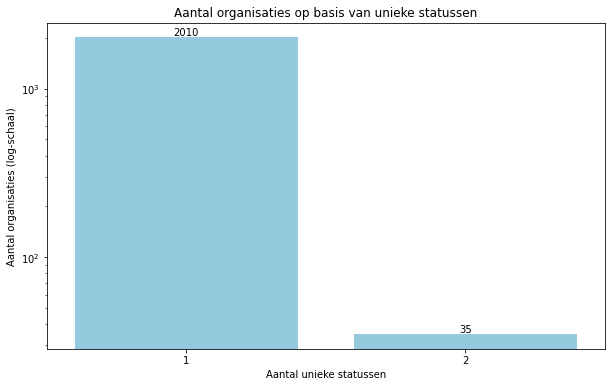

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the unique statuses per organization
org_status_counts = data.groupby('ORG_NAAM')['Status_faillissement'].nunique()

# Count the occurrences of each unique count
status_counts_summary = org_status_counts.value_counts().sort_index()

# Plot a bar plot with logarithmic scale and show count numbers on each bar
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts_summary.index, y=status_counts_summary.values, color='skyblue')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Aantal organisaties op basis van unieke statussen')
plt.xlabel('Aantal unieke statussen')
plt.ylabel('Aantal organisaties (log-schaal)')

# Display count numbers on each bar
for i, count in enumerate(status_counts_summary.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()




### Histogram van de faillissementsstatus in oplopende volgorde

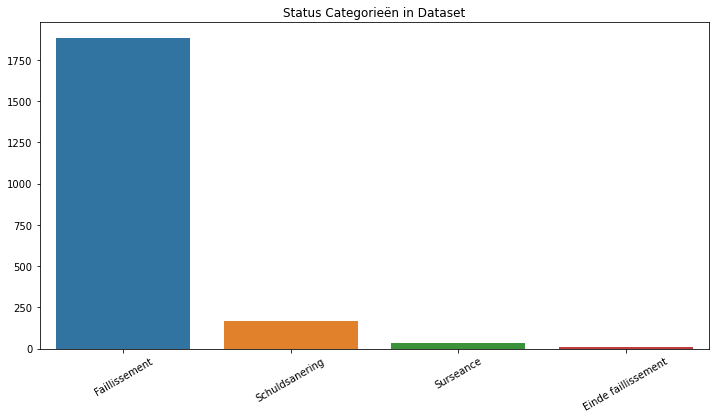

In [6]:
# Histogram van de faillissementsstatus in oplopende volgorde
plt.figure(figsize=(12, 6))
sns.countplot(x='Status_faillissement', data=data, order=data['Status_faillissement'].value_counts().index)
plt.xticks(rotation=30)
plt.title('Status Categorieën in Dataset')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Histogram Aantal Faillissementen en Totaal per Maand

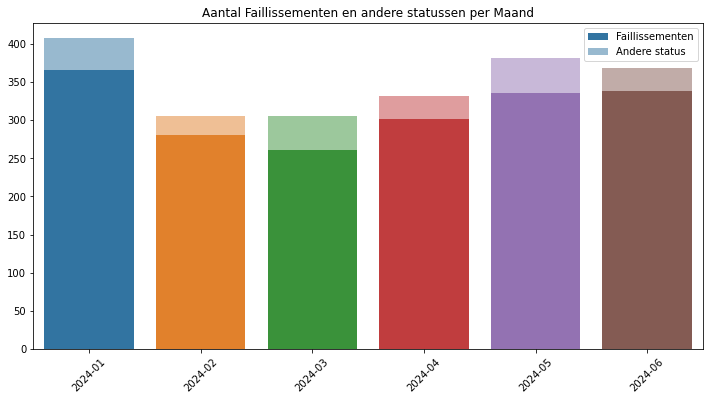

In [7]:
# Zorg ervoor dat de 'Datum' kolom een datetime formaat heeft
data['Datum'] = pd.to_datetime(data['Datum'])

# Voeg een kolom toe voor de maand
data['Maand'] = data['Datum'].dt.to_period('M')

# Groepeer de data per maand en tel het aantal faillissementen
maandelijkse_faillissementen = data[data['Status_faillissement'] == 'Faillissement'].groupby('Maand').size()

# Bereken het totaal aantal faillissementen per maand
totaal_per_maand = data.groupby('Maand').size()

# Maak een gecombineerde plot
plt.figure(figsize=(12, 6))
sns.barplot(x=maandelijkse_faillissementen.index.astype(str), y=maandelijkse_faillissementen.values, label='Faillissementen')
sns.barplot(x=totaal_per_maand.index.astype(str), y=totaal_per_maand.values, alpha=0.5, label='Andere status')
plt.xlabel('')
plt.ylabel('')
plt.title('Aantal Faillissementen en andere statussen per Maand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### standaard bedrijfsindeling (Sbi) beschriving toevoegen

In [8]:
# Lees het Excel-bestand met de SBI-codes
sbi_data = pd.read_excel('standaard_bedrijfsindeling_2008_excel1.xlsx')

# Zet de 'Sbi-code'-kolom naar integers
sbi_data['Sbi-code'] = pd.to_numeric(sbi_data['Sbi-code'], errors='coerce').round().astype('Int64')

# Merge de 'data'-DataFrame met de SBI-informatie
merged_data = pd.merge(data, sbi_data, how='left', on='Sbi-code')

### Subset Faillissementen 2024

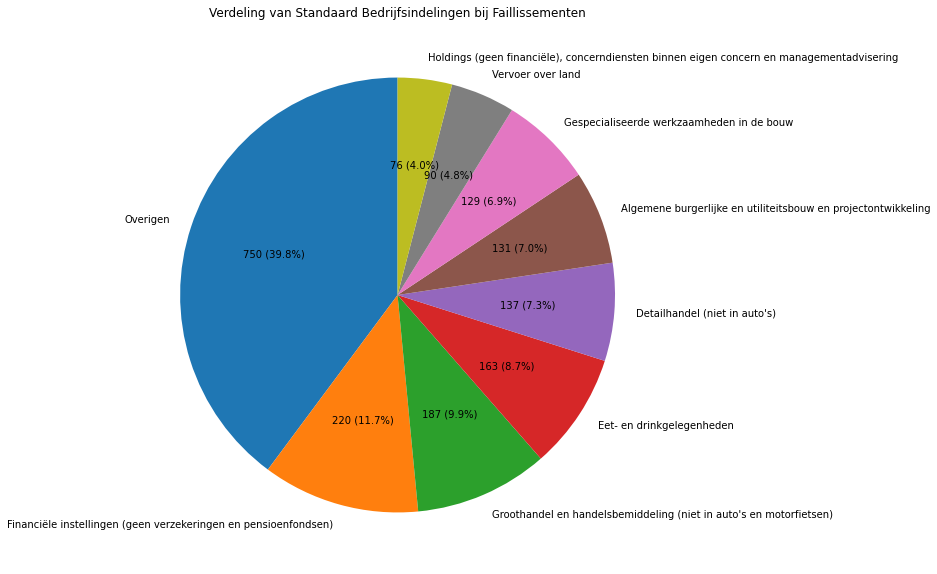

In [9]:
# Maak een subset met alleen 'faillissement' data
subset_faillissement = merged_data[merged_data['Status_faillissement'] == 'Faillissement'].copy()  # Maak een kopie om de SettingWithCopyWarning te vermijden

# Bereken de frequentie van elke SBI-code
sbi_counts = subset_faillissement['Standaard Bedrijfsindeling'].value_counts(normalize=True)

# Maak een nieuwe kolom 'Standaard Bedrijfsindeling_' en vul deze in met 'Overigen' waar de frequentie minder dan 3% is
subset_faillissement['Standaard Bedrijfsindeling_'] = subset_faillissement['Standaard Bedrijfsindeling'].apply(
    lambda x: 'Overigen' if sbi_counts.get(x, 0) < 0.03 else x
)

# Plot een taartdiagram van de verdeling van SBI-codes voor 'faillissement' data
plt.figure(figsize=(10, 10))
subset_faillissement['Standaard Bedrijfsindeling_'].value_counts().plot.pie(autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * len(subset_faillissement) / 100, p), startangle=90)
plt.title('Verdeling van Standaard Bedrijfsindelingen bij Faillissementen')
plt.ylabel('')  # Verwijder y-label om het overzicht te verbeteren
plt.show()

# Voeg 'ORG_PLAATS_1' kolom toe
subset_faillissement['ORG_PLAATS_1'] = subset_faillissement['ORG_PLAATS'] + ', The Netherlands'


# Vul lege waarden in de kolom 'Standaard Bedrijfsindeling_' met een lege string
subset_faillissement['Standaard Bedrijfsindeling_'] = subset_faillissement['Standaard Bedrijfsindeling_'].fillna('').astype(str)

# Voeg een nieuwe kolom 'icon_num' toe met waarde 1
subset_faillissement['icon_num'] = 1
